<a href="https://colab.research.google.com/github/SuperChicken566/ADL22/blob/main/Applying_CNN_chapter08_intro_to_dl_for_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

Previous `DNN` model:

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (28, 28, 1)
keras.backend.clear_session()

model_old = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Dense(512, activation="relu"), #hidden layer(s)
    layers.Dense(256, activation="relu"), #hidden layer(s)
    layers.Dense(128, activation="relu"), #hidden layer(s)
    layers.Dense(10, activation="softmax") #SPECIAL: output layer
])

In [2]:
model_old.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28, 28, 512)       1024      
                                                                 
 dense_1 (Dense)             (None, 28, 28, 256)       131328    
                                                                 
 dense_2 (Dense)             (None, 28, 28, 128)       32896     
                                                                 
 dense_3 (Dense)             (None, 28, 28, 10)        1290      
                                                                 
Total params: 166,538
Trainable params: 166,538
Non-trainable params: 0
_________________________________________________________________


Sample `Sequential` CNN model

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (28, 28, 1)
num_classes = 10
model = keras.Sequential(
    [
        keras.Input(shape=input_shape), #needed for summary
        layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu'),
        #layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10,activation='softmax')

      #COMPLETE MODEL to:
        #add 3 layers of conv+maxpool. 
        #conv: filters:32,64,128; kernel_zise:3, ReLU activation
        #maxpool: 2. Note: other pools, such as mean exist. 
        # This is "Best" for classification
        #but for other porblems, like generation, other solutions. IE: stride=2
        #
     
        #HEAD: 
        # #transition from CNN to DNN: Makes it 1-D (matrix to vector)
        #regularize here! 
        #activation for predicting 10 classes? 
    ]
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

We will try an alternative style: 

`Functional` API, instead of `Sequential`

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
keras.backend.clear_session()

inputs = keras.Input(shape=(28, 28, 1))
#See (inputs) at the end of line
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
#See x at the beginning and the end
x = layers.MaxPooling2D(pool_size=2)(x)
#Conv2D, MaxPooling2D are usually grouped for Classification

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#transition from CNN to DNN: Makes it 1-D (matrix to vector)
x = layers.Flatten()(x)
#output layer is same as before!
outputs = layers.Dense(num_classes, activation="softmax")(x)

#have to create an object as well:
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [ ]:
model.summary()

# what do you think conv2d filter does to shape?
# what about MaxPool?

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

"After the last Conv2D layer, we end up with an output of shape (3, 3, 128)
—a 3 × 3 feature map of 128 channels."

Dense layers "process vectors, which are 1D, whereas the current output is a rank-3 tensor. 
To bridge the gap, we flatten the 3D outputs to 1D with a Flatten layer before adding the Dense layers."

**Training the convnet on MNIST images**

This is the same problem from [Workshop 2 ](https://docs.google.com/document/u/0/d/1ml06LZzuQ0-4G1F_b3oHuxUJmMZHVvyCmaEzOt77hZc/edit)

Get data:

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255


11501568/11490434 [==============================] - 0s 0us/step


Train:

In [ ]:
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 14s 4ms/step - loss: 0.1562 - accuracy: 0.9508
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0421 - accuracy: 0.9874
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0297 - accuracy: 0.9913
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0235 - accuracy: 0.9926
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0178 - accuracy: 0.9944


**Evaluating the convnet**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0336 - accuracy: 0.9904
Test accuracy: 0.990


"Whereas the densely connected model from chapter 2 had a test accuracy of 97.8%, the basic convnet has a test accuracy of 99.1%: we decreased the error rate by about 60% (relative). Not bad!"

### The convolution operation

#### Understanding border effects and padding

#### Understanding convolution strides

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 61952)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainable

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

You need your kaggle account info.

navigate to [the Kaggle website](https://www.kaggle.com/) in a web browser, log in, and go to the My Account page. 

In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle(4).json to kaggle(4).json


{'kaggle(4).json': b'{"username":"reqsquirrel","key":"5a6f49983ea870edd01b59669f29492c"}'}

In [ ]:
!mv kaggle*.json kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.3MB/s]
 97% 264M/271M [00:01<00:00, 146MB/s]
100% 271M/271M [00:01<00:00, 146MB/s]
 98% 534M/543M [00:03<00:00, 168MB/s]
100% 543M/543M [00:03<00:00, 144MB/s]


In [ ]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [ ]:
!rm -rf cats_vs_dogs_small

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

Very similar `Functional` structure to MNIST CNN

Images are bigger (and we have more of them) -> Larger model


---


Note that each image is 180x180x3 pixels; 100x bigger than MNIST (28x28x1)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs) 
#NEW: range of each pixel scaled down from 255 to 1
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

Below is an efficient way to create a data pipeline for images. 


Good practice as images will be converted to tensors and GPU-friendly objects (`tf.data.Dataset`)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


`map()` Applies an arbitrary transformation to each element of the dataset

In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

What else is new? **callbacks**! 


Save model (w, performance, etc.) after each epoch as a file. 

Like a checkpoint


`save_best_only`: overwrite previously saved model when a better one (`val_loss`) is found. 

So if we are overfitting, we don't have to go back and manually re-train! 



In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/3
63/63 [==============================] - 169s 3s/step - loss: 0.6996 - accuracy: 0.5680 - val_loss: 0.6654 - val_accuracy: 0.6210
Epoch 2/3
63/63 [==============================] - 162s 3s/step - loss: 0.6385 - accuracy: 0.6445 - val_loss: 0.6272 - val_accuracy: 0.6360
Epoch 3/3
63/63 [==============================] - 164s 3s/step - loss: 0.6068 - accuracy: 0.6775 - val_loss: 0.6350 - val_accuracy: 0.6510


**Displaying curves of loss and accuracy during training**

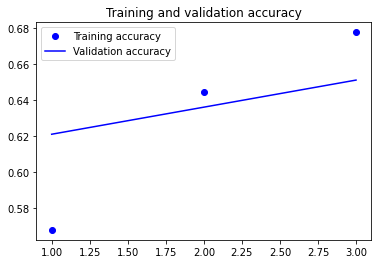

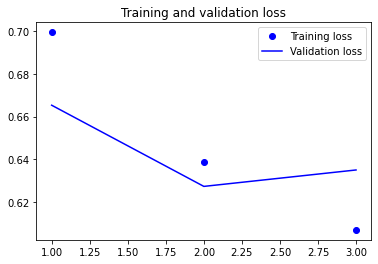

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%. 

The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds.

**Evaluating the model on the test set**

Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate it as it was before it started overfitting.

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 43s 678ms/step - loss: 0.6329 - accuracy: 0.6515
Test accuracy: 0.651


In [ ]:
test_model.save('test_model')

INFO:tensorflow:Assets written to: test_model/assets


About 70% accuracy on test. 

Need to 'generalize' on test better. 

How?
Specific tool for images to combat overfitting: generating new data from existing ones.

### Using data augmentation

**Define a data augmentation stage to add to an image model**

Adding a number of data augmentation layers at the start of your model. 

Let’s get started with an example: the following Sequential model chains several random image transformations. 

In our model, we’d include it right before the Rescaling layer.

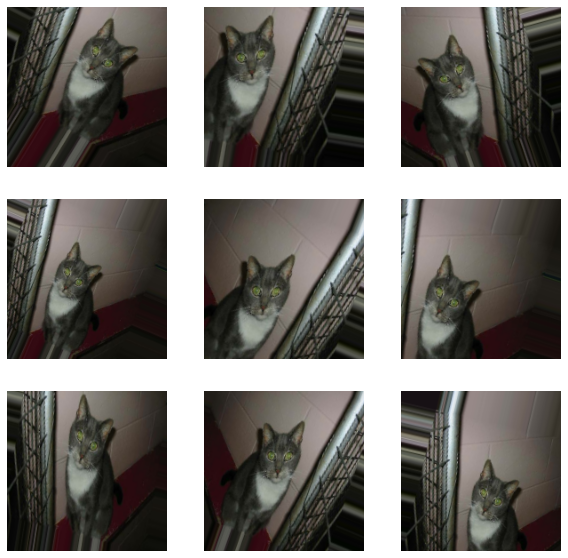

In [ ]:
#DEMO, not needed for CNN: 
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    augmented_images = aug.flow(images)
    for i in range(9):
        # print(augmented_images[0][0].shape)
        # augmented_images = images.map(lambda x: data_augmentation(x))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0][0].astype("uint8"))
        plt.axis("off")

In [ ]:
#New layer for our CNN
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  #range for random flip: 50%
        layers.RandomRotation(0.1),  #range for random rotation: +/- 10%
        layers.RandomZoom(0.2), #range for random zoom: +/- 20%
    ]
)

**Displaying some randomly augmented training images**

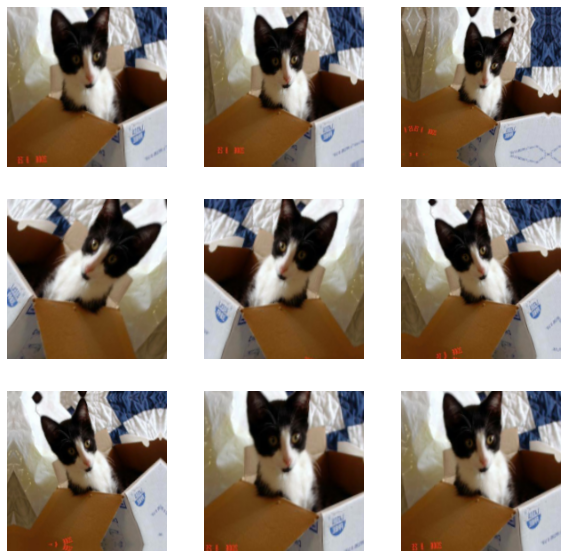

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        # augmented_images = images.map(lambda x: data_augmentation(x))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) #NEW
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x) #NEW
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

If we train a new model using this data-augmentation configuration, the model will **never* see the same input twice**. 

But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only **remix** existing information.

*: terms and conditions apply. ~unlikely

**Training the regularized convnet**

If this delays our overfitting, we should now be able to run our CNN for longer!

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 10s 122ms/step - loss: 0.7882 - accuracy: 0.5265 - val_loss: 0.6911 - val_accuracy: 0.6010
Epoch 2/100
63/63 [==============================] - 9s 131ms/step - loss: 0.6987 - accuracy: 0.5605 - val_loss: 0.6852 - val_accuracy: 0.5110
Epoch 3/100
63/63 [==============================] - 8s 120ms/step - loss: 0.6880 - accuracy: 0.5665 - val_loss: 0.6542 - val_accuracy: 0.5900
Epoch 4/100
63/63 [==============================] - 8s 119ms/step - loss: 0.6458 - accuracy: 0.6200 - val_loss: 0.7458 - val_accuracy: 0.5620
Epoch 5/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6408 - accuracy: 0.6535 - val_loss: 0.6331 - val_accuracy: 0.6050
Epoch 6/100
63/63 [==============================] - 8s 120ms/step - loss: 0.6256 - accuracy: 0.6570 - val_loss: 0.6465 - val_accuracy: 0.5860
Epoch 7/100
63/63 [==============================] - 8s 119ms/step - loss: 0.6097 - accuracy: 0.6585 - val_loss: 0.8353 - val_accuracy: 0.588

**Evaluating the model on the test set**

load the **best** model from callback

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 52ms/step - loss: 0.4504 - accuracy: 0.8110
Test accuracy: 0.811


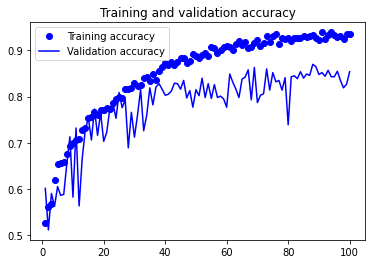

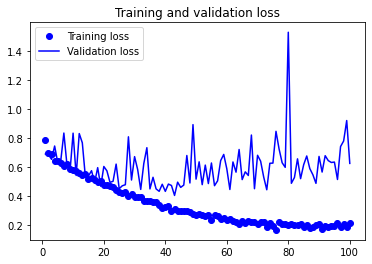

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Should score 80-85% accuracy on test

**Note:**
make sure you **download** the saved file (convnet_from_scratch_with_augmentation.keras), as we will use it for some experiments in the next chapter.

You can viz the NN using Netron:

https://github.com/lutzroeder/netron
or 

https://netron.app/

You may be able to tune this CNN to get ~90%!

Next approach is to fine-tune a larger network that learned on a large dataset for our purposes!

## Leveraging a pretrained model

> A pretrained model is a model that was previously trained on a **large dataset**, typically on a large-scale image-classification task.

If the model has learned from a large enough dataset, its features may be
> useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task. 



## Large Dataset: ImageNet 

Example of large dataset: [ImageNet](https://image-net.org/about.php). it has:


*   ~150 GB in size
*   Over a 14M images. 
*   ~20,000 categories
*   Many are animals and everyday objects

(including 100+ dog breeds)


Common subset with 1M+ images, 1,000 categories on [Kaggle](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description).



### Pretrained Model: VGG16


From Very Deep Convolutional Networks for Large-Scale Image Recognition (ICLR 2015):
https://arxiv.org/abs/1409.1556

Oldy, but goody. 

Newer ones can be faster and more accurate:
ResNet, Inception, Xception. 

Size, Speed and Accuracy of available models on Keras:
https://keras.io/api/applications/

2 ways to use a pretrained model: **feature extraction and fine-tuning**. 

We will also see 2 ways to extract features: QnD and slower but more flexible. 

**Instantiating the VGG16 convolutional base**

### Feature extraction with a pretrained model

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


> `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don’t need to include it. 

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

> using the representations learned by a previously trained model to extract interesting features from new samples. 

>These features are then run through a new classifier, which is trained from scratch.

> [Take] the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

<img src='https://drek4537l1klr.cloudfront.net/chollet2/HighResolutionFigures/figure_8-12.png'>

**Why only the Convolutional/base?**

More generic thx to feature maps

Drop the Dense layers.

**Remember the hierarchy**
> Layers that come earlier in the model extract local, highly generic feature maps (such as visual **edges**, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat **ear”** or “dog eye”). 

> So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

**Extracting the VGG16 features and corresponding labels**

2 approaches: 


1.   Save CNN output, feed to a new NN that predicts
2.   Append new layers to CNN as a single model.

Start with first one.



In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

Create Dense layers that takes in the shape of VGG features:

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 4s 48ms/step - loss: 18.7083 - accuracy: 0.9175 - val_loss: 5.3668 - val_accuracy: 0.9560
Epoch 2/20
63/63 [==============================] - 3s 44ms/step - loss: 2.6023 - accuracy: 0.9825 - val_loss: 11.4368 - val_accuracy: 0.9460
Epoch 3/20
63/63 [==============================] - 3s 44ms/step - loss: 2.6250 - accuracy: 0.9805 - val_loss: 10.4639 - val_accuracy: 0.9560
Epoch 4/20
63/63 [==============================] - 3s 44ms/step - loss: 1.0329 - accuracy: 0.9915 - val_loss: 5.4022 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 3s 45ms/step - loss: 1.2425 - accuracy: 0.9920 - val_loss: 5.1821 - val_accuracy: 0.9640
Epoch 6/20
63/63 [==============================] - 3s 44ms/step - loss: 0.8754 - accuracy: 0.9955 - val_loss: 3.8878 - val_accuracy: 0.9740
Epoch 7/20
63/63 [==============================] - 3s 43ms/step - loss: 0.9299 - accuracy: 0.9925 - val_loss: 4.5732 - val_accuracy: 0.9780
Epoch 8/20

**Plotting the results**

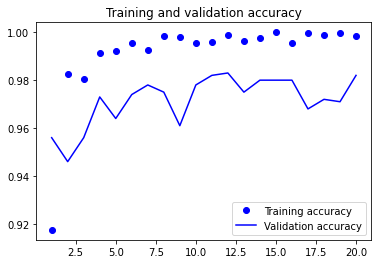

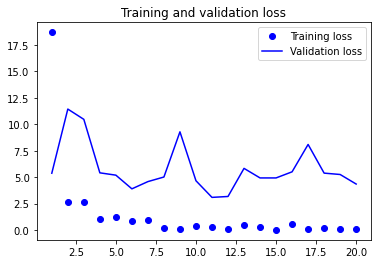

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

> validation accuracy of about 97%

Note that this is not VGG's first encounter with Cats and Dogs. Your results may vary.  

#### Feature extraction together with data augmentation

(CON) Slower than above

(CON) Cost more (computation wise)

(PRO) Allows more customization: 

Add data augmentation during training

**HOW?**

**Freeze** conv layers during training. So they don't learn/update.

`trainable = False`

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

**Adding a data augmentation stage and a classifier to the convolutional base**

Second feature extraction approach: 

> create a new model that chains together

1. A data augmentation stage (ours)
2. Our frozen convolutional base (VGG)
3. A dense classifier (ours)


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Note:** Since `conv_base` is frozen, only the Dense layer is trained.



**Note:** Since we adding augmentation to a bigger network, we can train even longer


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50, #such much
    validation_data=validation_dataset,
    callbacks=callbacks)

You probably don't want to run above without a GPU. It is expansive. 

If you don't have a GPU, see the method above (2 seperate netowrks, w/o augmentation)

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

validation accuracy of over 98%, but test accuracy of 97.5%

Compared to above: better validation, but similar test scores. 

### Fine-tuning a pretrained model

Second way to use a pre-trained model: Fine-tune

> unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers.

Fig 8-15:
<img src='https://drek4537l1klr.cloudfront.net/chollet2/HighResolutionFigures/figure_8-15.png'>

In [ ]:
conv_base.summary()

#### How to fine tune? 

Since we now have more parameters, we dont want to train it all at once. 

1.   Add our custom network on top of an already-trained base network.
1.   Freeze the base network.
1.   Train the part we added.
1.   Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on fine-tuning is explained in the next chapter.)
1.   Jointly train both these layers and the part we added. 

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Summary


*   CNN is good for Vision problems
*   Convolutional layers provide **Spatial hierarchy**
*   Can still overfit. Fight with data agumentation
*   Big data model: Feauture extraction (sandwich or fast)
*   Big data model: Fine-tuning


